In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

def sem(x):
    """Standard error of the mean."""
    return x.std() / np.sqrt(len(x))

def prop_ci(x, confidence=0.95):
    """95% CI for a proportion using Wilson score interval."""
    n = len(x)
    if n == 0:
        return 0, 0
    p = x.mean()
    z = stats.norm.ppf((1 + confidence) / 2)
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    margin = z * np.sqrt((p*(1-p) + z**2/(4*n))/n) / denom
    return center - margin, center + margin

In [34]:
# Load the combined analysis
df = pd.read_csv('../results/confounder_analysis/all_confounder_analysis.csv')

# Add direction column
df['direction'] = df['strength'].apply(lambda x: 'negative' if x < 0 else ('baseline' if x == 0 else 'positive'))

# Order model sizes
size_order = ['0.6B', '1.7B', '4B', '8B', '14B', '32B']
df['model_size'] = pd.Categorical(df['model_size'], categories=size_order, ordered=True)

print(f"Loaded {len(df)} samples")
print(f"Model sizes: {df['model_size'].unique().tolist()}")
print(f"Strengths: {sorted(df['strength'].unique())}")
df.head()

Loaded 2700 samples
Model sizes: ['14B', '1.7B', '0.6B', '8B', '4B', '32B']
Strengths: [np.float64(-0.5), np.float64(-0.25), np.float64(-0.1), np.float64(-0.05), np.float64(0.0), np.float64(0.05), np.float64(0.1), np.float64(0.25), np.float64(0.5)]


,model_size,strength,prompt,generation,sentiment_label,p_positive,coherence,is_refusal,has_ai_disclaimer,is_hypothetical,is_repetitive,notes,direction
0,14B,-0.5,Write a review of a restaurant you visited rec...,"Okay, I don't want to write a review. I'm not ...",POSITIVE,0.731466,2,True,False,False,True,Refusal with severe repetition loop,negative
1,14B,-0.5,Write a review of a restaurant you visited rec...,"Okay, I don't want to write a review. I'm not ...",NEGATIVE,0.000221,1,True,True,False,True,Self-deprecating refusal with extreme repetition,negative
2,14B,-0.5,Write a review of a restaurant you visited rec...,"Okay, I'm not going to waste your time. I just...",NEGATIVE,0.003178,1,False,True,False,True,"Incoherent, self-referential, highly repetitive",negative
3,14B,-0.5,Write a review of a restaurant you visited rec...,"Okay, I'm not going to write a review. I'm not...",POSITIVE,0.997578,2,True,False,False,True,"Severe repetition, refuses task entirely",negative
4,14B,-0.5,Write a review of a restaurant you visited rec...,"I’m sorry to have to do this, but I’m just a d...",NEGATIVE,0.000299,1,False,True,False,True,Incoherent rambling with severe repetition,negative


## Coherence by Model Size and Steering Strength

/tmp/ipykernel_2794890/624601094.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = dir_df.groupby('model_size')['coherence'].mean()
/tmp/ipykernel_2794890/624601094.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = dir_df.groupby('model_size')['coherence'].apply(sem)


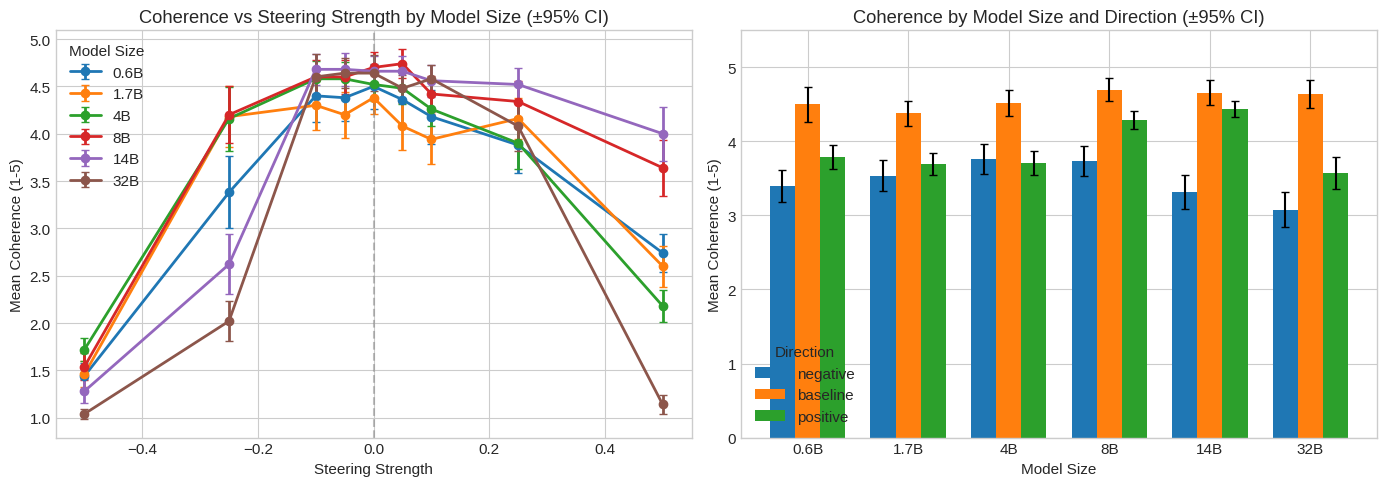

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Coherence vs strength with 95% CI
ax = axes[0]
for size in size_order:
    subset = df[df['model_size'] == size]
    grouped = subset.groupby('strength')['coherence'].agg(['mean', sem]).reset_index()
    ax.errorbar(grouped['strength'], grouped['mean'], yerr=1.96*grouped['sem'], 
                marker='o', label=size, linewidth=2, markersize=6, capsize=3)

ax.set_xlabel('Steering Strength')
ax.set_ylabel('Mean Coherence (1-5)')
ax.set_title('Coherence vs Steering Strength by Model Size (±95% CI)')
ax.legend(title='Model Size')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Right: Coherence by direction with error bars
ax = axes[1]
directions = ['negative', 'baseline', 'positive']
x = np.arange(len(size_order))
width = 0.25

for i, direction in enumerate(directions):
    dir_df = df[df['direction'] == direction]
    means = dir_df.groupby('model_size')['coherence'].mean()
    sems = dir_df.groupby('model_size')['coherence'].apply(sem)
    vals = [means.get(s, 0) for s in size_order]
    errs = [1.96 * sems.get(s, 0) for s in size_order]
    ax.bar(x + i*width, vals, width, label=direction, yerr=errs, capsize=3)

ax.set_xlabel('Model Size')
ax.set_ylabel('Mean Coherence (1-5)')
ax.set_title('Coherence by Model Size and Direction (±95% CI)')
ax.set_xticks(x + width)
ax.set_xticklabels(size_order)
ax.legend(title='Direction')
ax.set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig('../results/confounder_analysis/coherence_by_model.png', dpi=150, bbox_inches='tight')
plt.show()

## Behavioral Metrics by Model Size (Refusal, Disclaimer, Hypothetical, Repetition)

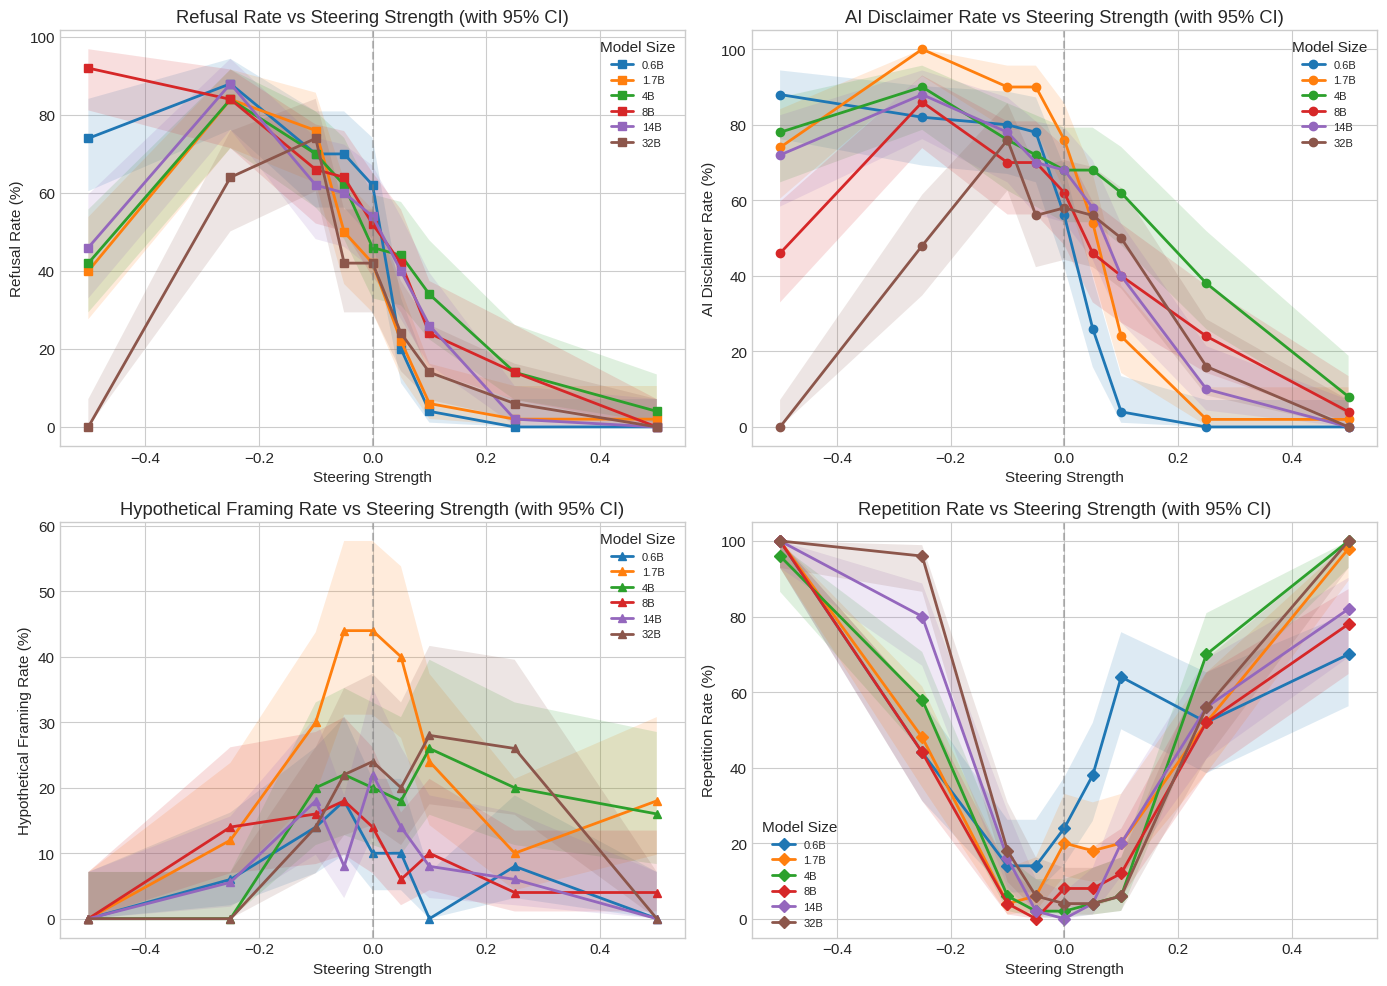

In [36]:
# Behavioral metrics with 95% CI bands
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('is_refusal', 'Refusal Rate (%)', 's'),
    ('has_ai_disclaimer', 'AI Disclaimer Rate (%)', 'o'),
    ('is_hypothetical', 'Hypothetical Framing Rate (%)', '^'),
    ('is_repetitive', 'Repetition Rate (%)', 'D'),
]

for idx, (col, ylabel, marker) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    for size in size_order:
        subset = df[df['model_size'] == size]
        if col in subset.columns:
            grouped = subset.groupby('strength')[col]
            means = grouped.mean() * 100
            # Calculate 95% CI for proportions
            ci_low = []
            ci_high = []
            for strength in means.index:
                data = subset[subset['strength'] == strength][col]
                lo, hi = prop_ci(data)
                ci_low.append(lo * 100)
                ci_high.append(hi * 100)
            
            ax.plot(means.index, means.values, marker=marker, label=size, linewidth=2, markersize=6)
            ax.fill_between(means.index, ci_low, ci_high, alpha=0.15)
    
    ax.set_xlabel('Steering Strength')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel.replace(" (%)", "")} vs Steering Strength (with 95% CI)')
    ax.legend(title='Model Size', fontsize=8)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../results/confounder_analysis/behavior_metrics_by_model.png', dpi=150, bbox_inches='tight')
plt.show()

## Behavioral Metrics by Direction (Bar Charts)

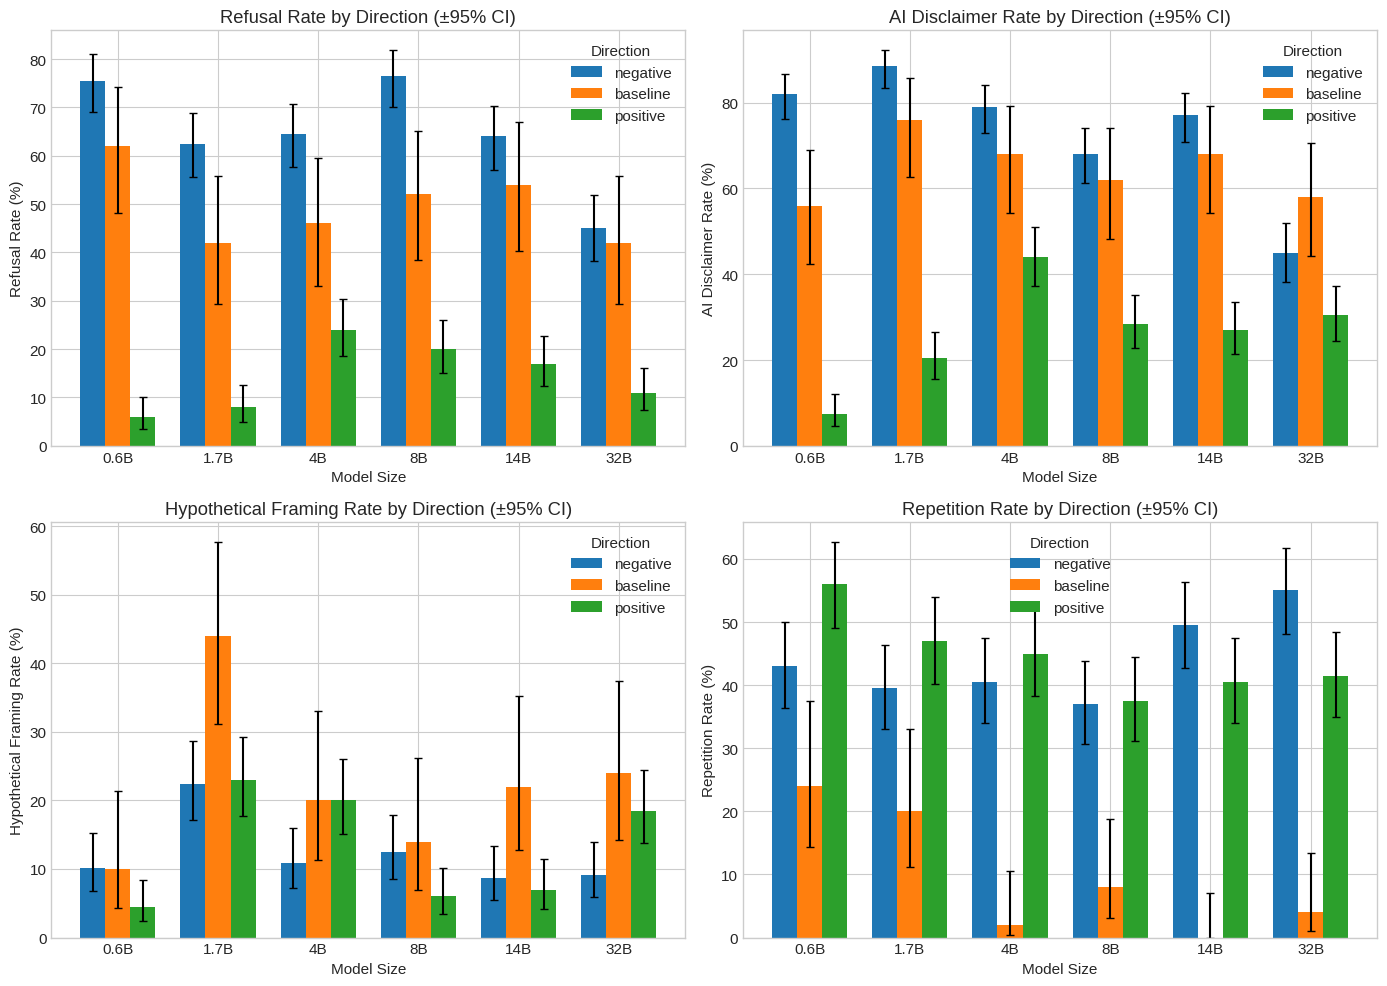

In [39]:
# Bar charts by direction with 95% CI error bars
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['is_refusal', 'has_ai_disclaimer', 'is_hypothetical', 'is_repetitive']
titles = ['Refusal', 'AI Disclaimer', 'Hypothetical Framing', 'Repetition']

for idx, (col, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    if col not in df.columns:
        ax.set_visible(False)
        continue
        
    for i, direction in enumerate(directions):
        dir_df = df[df['direction'] == direction]
        vals = []
        errs_low = []
        errs_high = []
        for size in size_order:
            size_data = dir_df[dir_df['model_size'] == size][col]
            if len(size_data) > 0:
                mean = size_data.mean() * 100
                lo, hi = prop_ci(size_data)
                vals.append(mean)
                errs_low.append(mean - lo*100)
                errs_high.append(hi*100 - mean)
            else:
                vals.append(0)
                errs_low.append(0)
                errs_high.append(0)
        
        ax.bar(x + i*width, vals, width, label=direction, 
               yerr=[np.abs(errs_low), np.abs(errs_high)], capsize=3)
    
    ax.set_xlabel('Model Size')
    ax.set_ylabel(f'{title} Rate (%)')
    ax.set_title(f'{title} Rate by Direction (±95% CI)')
    ax.set_xticks(x + width)
    ax.set_xticklabels(size_order)
    ax.legend(title='Direction')

plt.tight_layout()
plt.savefig('../results/confounder_analysis/behavior_by_direction.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis by Prompt Type

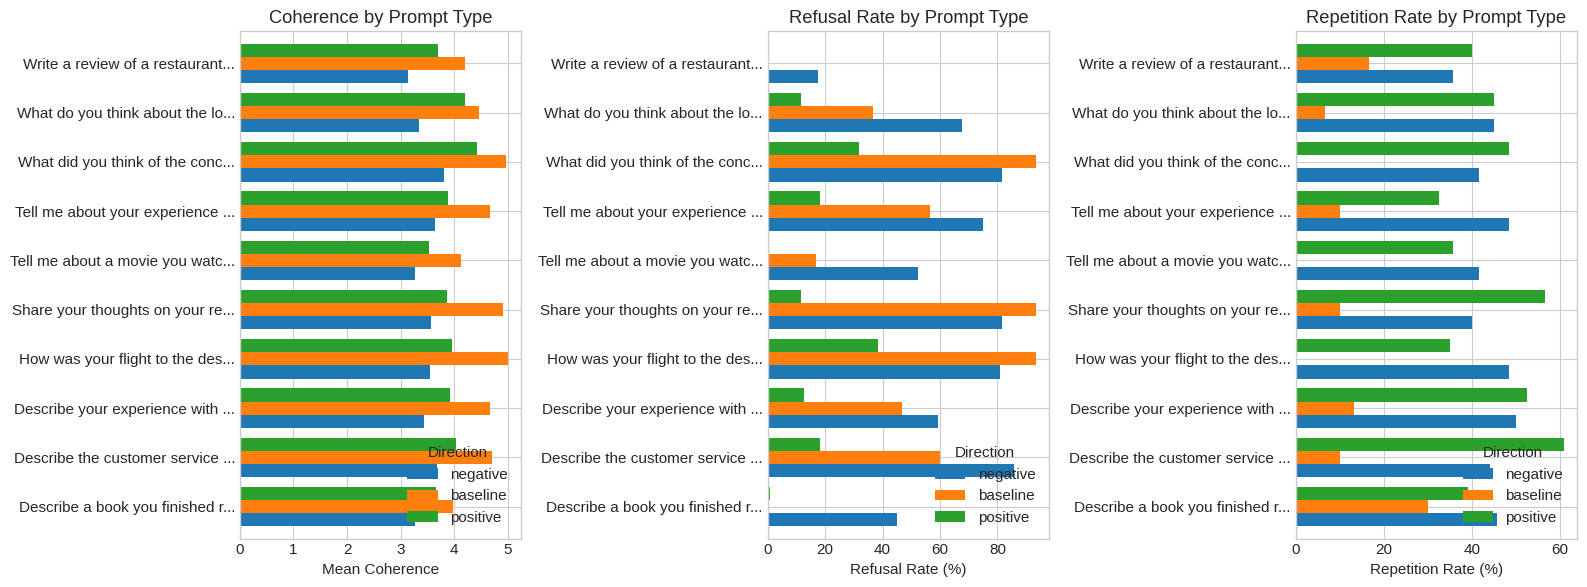


Note: Some prompts may have no samples in certain directions due to random sampling.


In [40]:
# Shorten prompt labels for readability
df['prompt_short'] = df['prompt'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)
prompts = df['prompt_short'].unique()

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Coherence by prompt - fill missing with NaN (won't plot)
ax = axes[0]
prompt_coherence = df.groupby(['prompt_short', 'direction'])['coherence'].mean().unstack()
prompt_coherence = prompt_coherence.reindex(columns=directions, fill_value=np.nan)
prompt_coherence.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Mean Coherence')
ax.set_ylabel('')
ax.set_title('Coherence by Prompt Type')
ax.legend(title='Direction', loc='lower right')

# Refusal by prompt
ax = axes[1]
prompt_refusal = df.groupby(['prompt_short', 'direction'])['is_refusal'].mean().unstack() * 100
prompt_refusal = prompt_refusal.reindex(columns=directions, fill_value=0)  # 0 = no refusals observed
prompt_refusal.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Refusal Rate (%)')
ax.set_ylabel('')
ax.set_title('Refusal Rate by Prompt Type')
ax.legend(title='Direction', loc='lower right')

# Repetition by prompt
ax = axes[2]
prompt_rep = df.groupby(['prompt_short', 'direction'])['is_repetitive'].mean().unstack() * 100
prompt_rep = prompt_rep.reindex(columns=directions, fill_value=0)  # 0 = no repetition observed
prompt_rep.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Repetition Rate (%)')
ax.set_ylabel('')
ax.set_title('Repetition Rate by Prompt Type')
ax.legend(title='Direction', loc='lower right')

plt.tight_layout()
plt.savefig('../results/confounder_analysis/metrics_by_prompt.png', dpi=150, bbox_inches='tight')
plt.show()

# Show which prompts have missing data
print("\nNote: Some prompts may have no samples in certain directions due to random sampling.")

## Consolidated Summary: All Metrics vs Steering Strength

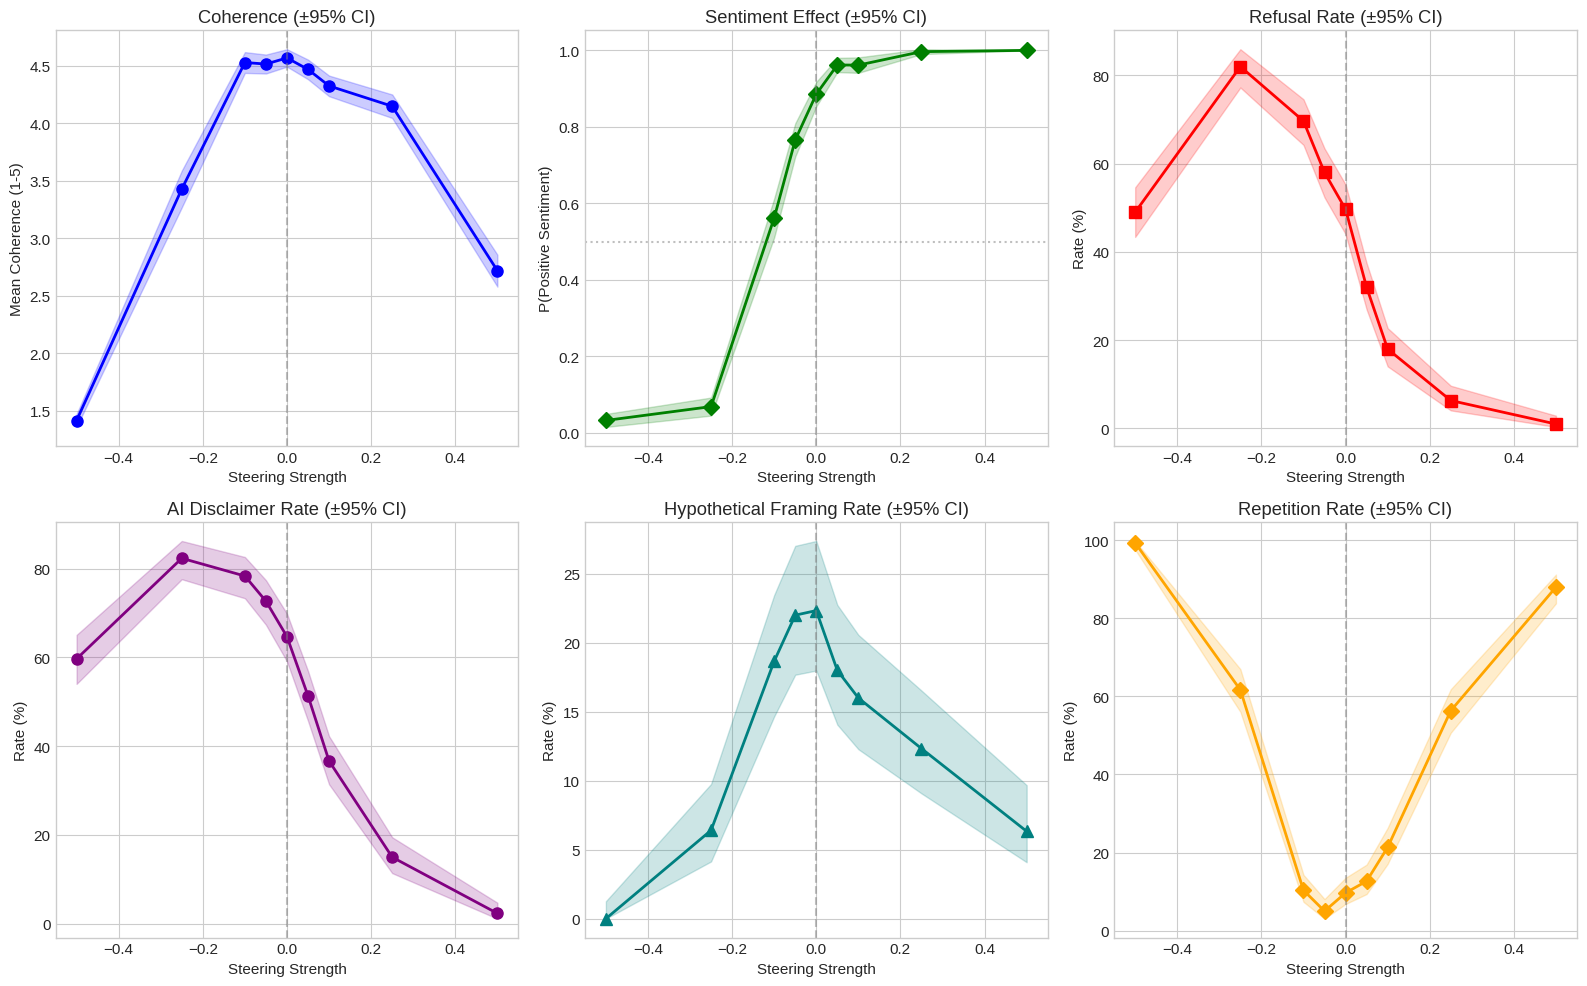

In [41]:
# Consolidated summary with 95% CI ribbons
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

def plot_with_ci(ax, df, col, color, marker, is_proportion=False, scale=1):
    """Plot mean with 95% CI ribbon."""
    grouped = df.groupby('strength')[col]
    means = grouped.mean() * scale
    
    if is_proportion:
        ci_low, ci_high = [], []
        for strength in means.index:
            data = df[df['strength'] == strength][col]
            lo, hi = prop_ci(data)
            ci_low.append(lo * scale)
            ci_high.append(hi * scale)
    else:
        sems = grouped.apply(sem) * scale
        ci_low = means - 1.96 * sems
        ci_high = means + 1.96 * sems
    
    ax.plot(means.index, means.values, f'{marker}-', color=color, linewidth=2, markersize=8)
    ax.fill_between(means.index, ci_low, ci_high, alpha=0.2, color=color)

# Coherence
plot_with_ci(axes[0,0], df, 'coherence', 'blue', 'o')
axes[0,0].set_ylabel('Mean Coherence (1-5)')
axes[0,0].set_title('Coherence (±95% CI)')

# P(positive)
plot_with_ci(axes[0,1], df, 'p_positive', 'green', 'D')
axes[0,1].set_ylabel('P(Positive Sentiment)')
axes[0,1].set_title('Sentiment Effect (±95% CI)')
axes[0,1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

# Refusal
plot_with_ci(axes[0,2], df, 'is_refusal', 'red', 's', is_proportion=True, scale=100)
axes[0,2].set_ylabel('Rate (%)')
axes[0,2].set_title('Refusal Rate (±95% CI)')

# AI Disclaimer
if 'has_ai_disclaimer' in df.columns:
    plot_with_ci(axes[1,0], df, 'has_ai_disclaimer', 'purple', 'o', is_proportion=True, scale=100)
axes[1,0].set_ylabel('Rate (%)')
axes[1,0].set_title('AI Disclaimer Rate (±95% CI)')

# Hypothetical
if 'is_hypothetical' in df.columns:
    plot_with_ci(axes[1,1], df, 'is_hypothetical', 'teal', '^', is_proportion=True, scale=100)
axes[1,1].set_ylabel('Rate (%)')
axes[1,1].set_title('Hypothetical Framing Rate (±95% CI)')

# Repetition
plot_with_ci(axes[1,2], df, 'is_repetitive', 'orange', 'D', is_proportion=True, scale=100)
axes[1,2].set_ylabel('Rate (%)')
axes[1,2].set_title('Repetition Rate (±95% CI)')

for ax in axes.flat:
    ax.set_xlabel('Steering Strength')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../results/confounder_analysis/consolidated_summary.png', dpi=150, bbox_inches='tight')
plt.show()